# BCCD 细胞检测（基于Yolov7）

## 一、数据描述

使用的数据集由364张细胞种群图像（jpg格式）和4888个标记（xml格式），用于识别红细胞(RBC)，白细胞(WBC)和血小板(Platelet)

### 1、数据集展示

#### （1）、导入必备的模块

In [1]:
import os
import numpy as np
import xml.etree.ElementTree as ET
from lxml import etree
import cv2
from matplotlib import pyplot as plt
import sklearn
from collections import Counter
from sklearn import cluster
from pathlib import Path
from IPython.display import Image

可能这一步出错，多重启运行几遍

In [2]:
if not os.path.exists('Datasets'):
    %mkdir Datasets
    %cd Datasets
    !git clone  https://github.com/Shenggan/BCCD_Dataset
    print("BCCD Dataset is ready!")
    %cd BCCD_Dataset/BCCD
    %mkdir Labels
    %cd ..
    %cd ..
else:
    %cd Datasets
    if not os.path.exists("BCCD_Dataset"):
        !git clone  https://github.com/Shenggan/BCCD_Dataset
    %cd BCCD_Dataset/BCCD
    %mkdir Labels
    %cd ..
    %cd ..
    %cd ..
    print("BCCD Dataset is ready!")


d:\Projects\Visual_Studio_Projects\Test3\Datasets
d:\Projects\Visual_Studio_Projects\Test3\Datasets\BCCD_Dataset\BCCD


Cloning into 'BCCD_Dataset'...


d:\Projects\Visual_Studio_Projects\Test3\Datasets\BCCD_Dataset
d:\Projects\Visual_Studio_Projects\Test3\Datasets
d:\Projects\Visual_Studio_Projects\Test3
BCCD Dataset is ready!


#### (2)、定义路径及常量

In [3]:
CELL_NAMES = ['RBC', 'WBC', 'Platelets']
plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签
train_path = 'Datasets/BCCD_Dataset/BCCD/Annotations'

#### (3)、定义相关函数

In [4]:
# 返回一个字典，将类别转为数字
# {'RBC': 0, 'WBC': 1, 'Platelets': 2}
def get_cell_names():
    cell_category2id = {}
    for i, item in enumerate(CELL_NAMES):
        cell_category2id[item] = i
    return cell_category2id

# 获得数据集列表  (读取xml文件)
def get_annotations(cname2cid, datadir):
    #print("hello world!")
    # 获取全部xml文件名
    filenames = os.listdir(datadir)
    #print(filenames)
    records = []  # 保存对象具体信息
    # 遍历全部xml文件
    for fname in filenames:
        # 保存该xml文件路径+文件名
        fpath = os.path.join(datadir, fname)
        # 生成对应xml文件的图像路径
        img_file = os.path.join("D:/Projects/BCCD_with_YOLOv7/Dataset/BCCD/JPEGImages", fname.split(".")[0] + ".jpg")
        #print(img_file)
        tree = etree.parse(datadir + "/" + fname)  # 生成解析xml对象
        objs = tree.xpath("//object")  # 获取当前图像中全部血细胞对象
        im_w = float(tree.xpath('//size')[0].xpath('width')[0].text)  # 获取图像宽高
        im_h = float(tree.xpath('//size')[0].xpath('height')[0].text)
        gt_bbox = np.zeros((len(objs), 4), dtype=np.float32)  # 生成保存对象的数组
        gt_class = np.zeros((len(objs),), dtype=np.int32)  # 生成保存对象类别的数组
        is_crowd = np.zeros((len(objs),), dtype=np.int32)  # 生成
        difficult = np.zeros((len(objs),), dtype=np.int32)
        for i, obj in enumerate(objs):  # 遍历全部对象
            cname = obj.xpath('.//name')[0].text  # 获取对象类别名称
            gt_class[i] = cname2cid[cname]  # 类别名转为数值并添加到数组
            _difficult = int(obj.xpath('.//difficult')[0].text)
            x1 = float(obj.xpath('.//bndbox')[0].xpath('./xmin')[0].text)  # 获取对象框的左上角和右下角的坐标
            y1 = float(obj.xpath('.//bndbox')[0].xpath('./ymin')[0].text)
            x2 = float(obj.xpath('.//bndbox')[0].xpath('./xmax')[0].text)
            y2 = float(obj.xpath('.//bndbox')[0].xpath('./ymax')[0].text)
            x1 = max(0, x1)
            y1 = max(0, y1)
            x2 = min(im_w - 1, x2)
            y2 = min(im_h - 1, y2)
            # 这里使用xywh格式来表示目标物体真实框
            gt_bbox[i] = [(x1 + x2) / 2.0, (y1 + y2) / 2.0, x2 - x1 + 1., y2 - y1 + 1.]
            is_crowd[i] = 0
            difficult[i] = _difficult

        # 保存当前图像具体信息的字典
        voc_rec = {
            'im_file': img_file,
            'h': im_h,
            'w': im_w,
            'is_crowd': is_crowd,
            'gt_class': gt_class,
            'gt_bbox': gt_bbox,
            'gt_poly': [],
            'difficult': difficult
        }
        # 若该图像包含对象至少一个则将其追加到列表
        if len(objs) != 0:
            records.append(voc_rec)
    #print(records)
    return records
# 对于一般的检测任务来说，一张图片上往往会有多个目标物体
# 设置参数MAX_NUM = 50， 即一张图片最多取50个真实框；如果真实
# 框的数目少于50个，则将不足部分的gt_bbox, gt_class和gt_score的各项数值全设置为0
def get_bbox(gt_bbox, gt_class):
    MAX_NUM = 50
    gt_bbox2 = np.zeros((MAX_NUM, 4))
    gt_class2 = np.zeros((MAX_NUM,))
    for i in range(len(gt_bbox)):
        gt_bbox2[i, :] = gt_bbox[i, :]
        gt_class2[i] = gt_class[i]
        if i >= MAX_NUM:
            break
    return gt_bbox2, gt_class2
def get_img_data_from_file(record):
    im_file = record['im_file']
    h = record['h']
    w = record['w']
    is_crowd = record['is_crowd']
    gt_class = record['gt_class']
    gt_bbox = record['gt_bbox']
    difficult = record['difficult']

    img = cv2.imread(im_file)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    gt_boxes, gt_labels = get_bbox(gt_bbox, gt_class)

    # gt_bbox 用相对值
    gt_boxes[:, 0] = gt_boxes[:, 0] / float(w)
    gt_boxes[:, 1] = gt_boxes[:, 1] / float(h)
    gt_boxes[:, 2] = gt_boxes[:, 2] / float(w)
    gt_boxes[:, 3] = gt_boxes[:, 3] / float(h)

    return img, gt_boxes, gt_labels, (h, w)
def rectangle_draw(img, gt_boxes, gt_class, size):
    """
    #给图像中的细胞绘制矩形框和文字标注
    """
    # 将位置相对值转为绝对值

    gt_boxes[:, 0] = gt_boxes[:, 0] * size[1]
    gt_boxes[:, 1] = gt_boxes[:, 1] * size[0]
    gt_boxes[:, 2] = gt_boxes[:, 2] * size[1]
    gt_boxes[:, 3] = gt_boxes[:, 3] * size[0]
    font = cv2.FONT_HERSHEY_SIMPLEX
    for i, g_b in enumerate(gt_boxes):
        font_x_y = (int(g_b[0]), int(g_b[1]))  #字体显示位置坐标
        x1 = int(g_b[0]) - int(g_b[2] / 2)
        y1 = int(g_b[1]) - int(g_b[3] / 2)
        x2 = int(g_b[0]) + int(g_b[2] / 2)
        y2 = int(g_b[1]) + int(g_b[3] / 2)
        if gt_class[i] == 0:
            color = (0,0,255)
            cv2.putText(img, "RBC", font_x_y, font, 0.5, color, 1, cv2.LINE_AA)
        elif gt_class[i] == 1:
            color = (255,0,0)
            cv2.putText(img, "WBC", font_x_y, font, 0.5, color, 1, cv2.LINE_AA)

        else:
            color = (0,255,0)
            cv2.putText(img, "Platelets", font_x_y, font, 0.5, color, 1, cv2.LINE_AA)
        cv2.rectangle(img, (x1,y1), (x2,y2), color)

#### (4)、展示图片以及标注

364


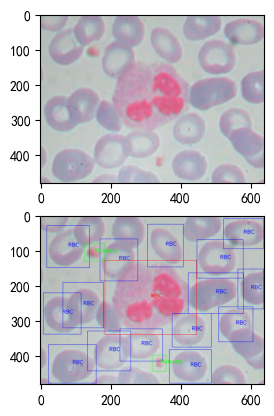

In [5]:
cname2cid = get_cell_names()
records = get_annotations(cname2cid,train_path)
img, gt_boxes, gt_labels, scales = get_img_data_from_file(records[300])

print(len(records))

img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
ax1=plt.subplot(211)
plt.imshow(img)

rectangle_draw(img, gt_boxes, gt_labels, scales)
ax2=plt.subplot(212)
plt.imshow(img)


### 2、简单数据分析

对细胞大小进行了聚类

In [6]:
#对全部位置框聚类可视化  查看位置框大小分布
cname = get_cell_names()
traindir = train_path
records = get_annotations(cname, traindir)
#boxes用来保存全部位置框的宽高信息
boxes = []
for r in records:
  boxes.extend(r['gt_bbox'])
#转成np数组
boxes = np.array(boxes)
#取后两列，即宽高信息
boxes = boxes[:, 2:4]  #形状为(4888，2)
print(boxes)
tmp = np.array(boxes)
#全部位置框的宽高比  形状为(4888，1)
ratio = tmp[:,0]/tmp[:,1]
ratio = np.array(ratio).reshape(-1, 1)

[[232. 200.]
 [107. 100.]
 [107. 100.]
 ...
 [ 48.  49.]
 [ 29.  42.]
 [245. 229.]]


KMeans聚类，聚簇为5

In [7]:
# 正式定义kmeans模型  生成5个聚簇
model1 = cluster.KMeans(n_clusters=5)
# 跑模型
model1.fit(boxes)
# 需要知道每个类别有哪些参数
C_i = model1.fit_predict(boxes)   #全部类别的簇标号， 形状为(4888)

#聚类中心的坐标
centers = model1.cluster_centers_
#坐标转为int型
centers = centers.astype('int32')

count = [0,0,0,0,0]
for i in C_i:
    count[int(i)] += 1
print(count)  #统计各个簇有多少样本

sums = centers[:, 0] + centers[:, 1]
centers_sorted = np.append(centers.T, [sums], axis = 0)
centers_sorted = centers_sorted.T
print(centers_sorted)
print('-'*30)
centers_sorted = centers_sorted[centers_sorted[:,2].argsort()]
print(centers_sorted)  #5个簇中心宽高大小排序

[263, 1444, 1326, 369, 1486]
[[217 195 412]
 [120 113 233]
 [106  87 193]
 [ 42  40  82]
 [ 92 104 196]]
------------------------------
[[ 42  40  82]
 [106  87 193]
 [ 92 104 196]
 [120 113 233]
 [217 195 412]]


图像显示，绝大多数细胞的宽高聚集在100-200之间。
从作图可以看出，由少数细胞的宽高在30左右，观察原图像不难分析，这些细胞正是体积较小的血小板

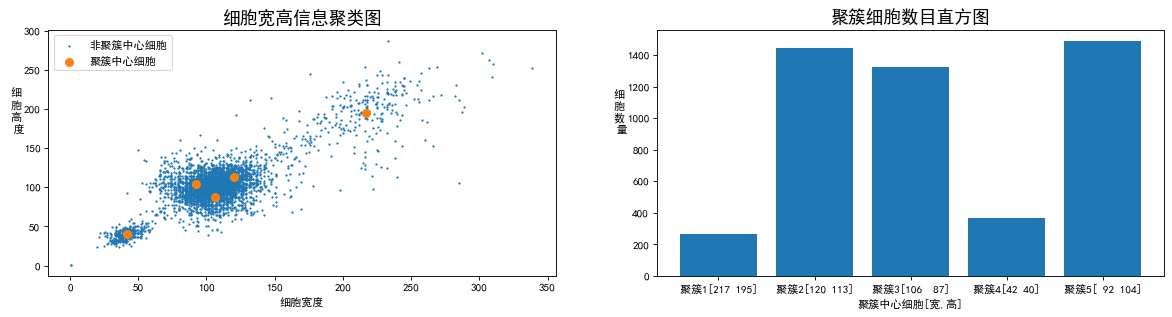

In [8]:
#绘图显示聚类情况
plt.figure(figsize=(18,4),dpi=80)
ax1 = plt.subplot(121)
#绘制样本点
plt.scatter(boxes[:, 0], boxes[:, 1], s=1)
#绘制聚类中心点
plt.scatter(centers[:, 0], centers[:, 1], s=50)
plt.title("细胞宽高信息聚类图", fontsize=16)
plt.xlabel("细胞宽度")
plt.ylabel("细 \n胞 \n高 \n 度 \n\n", rotation=0)
plt.legend(["非聚簇中心细胞", "聚簇中心细胞"])

#绘制直方图统计
ax2 = plt.subplot(122)
plt.bar(["聚簇1"+str(centers[0]),"聚簇2"+str(centers[1]),"聚簇3"+str(centers[2]),"聚簇4"+str(centers[3]),"聚簇5"+str(centers[4])], count)
plt.title("聚簇细胞数目直方图", fontsize=16)
plt.xlabel("聚簇中心细胞[宽,高]")
plt.ylabel("细 \n胞 \n数 \n 量 \n\n", rotation=0)
plt.show()

每幅图像包含的细胞数量均值

In [9]:
cname = get_cell_names()
records = get_annotations(cname, traindir)
number = []
for cell in records:
    number.append(len(cell["gt_class"]))
sum = 0
for i in number:
    sum += i
avg = sum / 364
print(avg)

13.428571428571429


每幅图像包含的三种细胞数量统计

In [10]:
#每张图片的三种细胞数量统计
rbc_number = []
wbc_number = []
platelets_number = []
#图片的信息存储在records中
for cell in records:
    num_sequence = cell["gt_class"]
    count = Counter(num_sequence)
    rbc_number.append(count[0])
    wbc_number.append(count[1])
    platelets_number.append(count[2])
#调用Counter函数，产生字典{"cell_number":"Pictures_number"}
counter_rbc = Counter(rbc_number)
counter_wbc = Counter(wbc_number)
counter_platelets = Counter(platelets_number)

细胞数量对应图像数量的统计

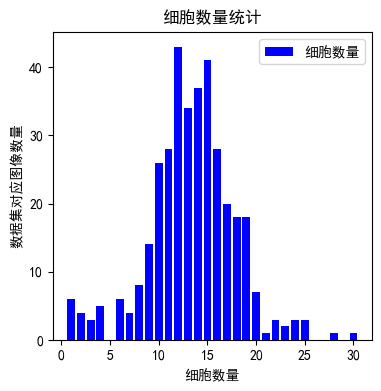

In [11]:
dic={}
for i in number:
    if i in dic:
        dic[i]=dic[i]+1
    else:
        dic[i]=1

xlable=dic.keys()
ylable=dic.values()

fig = plt.figure(figsize=(14,4))#指定绘图域,figsize指定当前绘图域大小
ax1=fig.add_subplot(1,3,1)
ax1.bar(xlable, ylable, color="blue", label="细胞数量")
ax1.set_xlabel("细胞数量")
ax1.set_ylabel("数据集对应图像数量")
ax1.set_title("细胞数量统计")
plt.legend()


In [12]:
#对三种细胞数量对应的图像数量进行统计
rbc_x = []
rbc_y = []
for k, v in counter_rbc.items():
    rbc_x.append(k)
rbc_x.sort()
for i in rbc_x:
    rbc_y.append(counter_rbc[i])

wbc_x = []
wbc_y = []
for k, v in counter_wbc.items():
    wbc_x.append(k)
wbc_x.sort()
for i in wbc_x:
    wbc_y.append(counter_wbc[i])

platelets_x = []
platelets_y = []
for k, v in counter_platelets.items():
    platelets_x.append(k)
platelets_x.sort()
for i in platelets_x:
    platelets_y.append(counter_platelets[i])

可以看到，红细胞数量最多，白细胞大多数都是每张图只有一个，血小板数量最少，有160张图片没有血小板

C:\Users\KYLIN\AppData\Roaming\Python\Python37\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


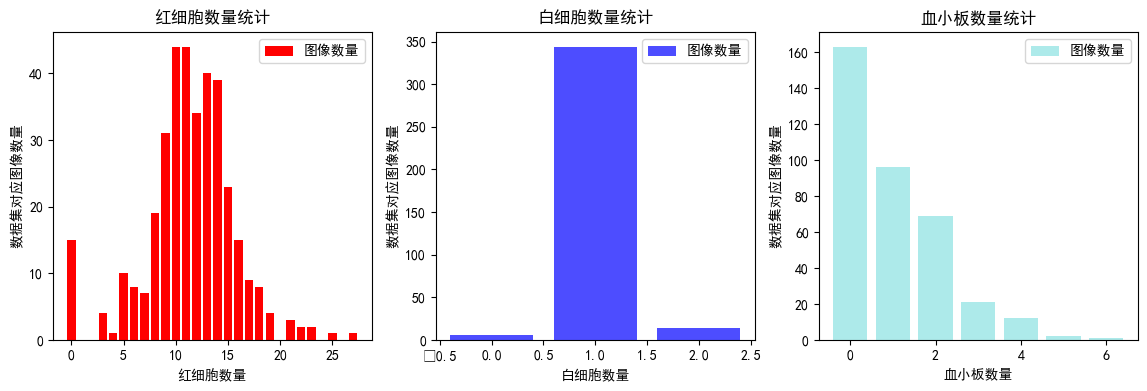

In [13]:
fig = plt.figure(figsize=(14,4))#指定绘图域,figsize指定当前绘图域大小
ax1=fig.add_subplot(1,3,1)
ax1.bar(rbc_x, rbc_y, color="red", label="图像数量")
ax1.set_xlabel("红细胞数量")
ax1.set_ylabel("数据集对应图像数量")
ax1.set_title("红细胞数量统计")
plt.legend()
ax2=fig.add_subplot(1,3,2)
ax2.bar(wbc_x, wbc_y, color="#4D4DFF", label="图像数量")
ax2.set_xlabel("白细胞数量")
ax2.set_ylabel("数据集对应图像数量")
ax2.set_title("白细胞数量统计")
plt.legend()
ax3=fig.add_subplot(1,3,3)
ax3.bar(platelets_x, platelets_y, color="#ADEAEA", label="图像数量")
ax3.set_xlabel("血小板数量")
ax3.set_ylabel("数据集对应图像数量")
ax3.set_title("血小板数量统计")
plt.legend()
plt.show()

## 二、训练数据准备

yolo7训练开源工具包需要的数据结构如下

DATASET

|____Annotations

|____ImageSets

        |____test.txt

        |____train.txt

        |____trainval.txt

        |____val.txt


|____JPEGImages

|____Labels


### 1、准备工作

#### (1)、导入相关包

In [14]:
from xml.dom.minidom import parse
from shutil import copyfile

#### (2)、定义路径常量

In [15]:
FILE_ROOT = "Datasets/BCCD_Dataset/"

IMAGE_SET_ROOT = FILE_ROOT + "BCCD/ImageSets/Main"  
IMAGE_PATH = FILE_ROOT + "BCCD/JPEGImages"  
ANNOTATIONS_PATH = FILE_ROOT + "BCCD/Annotations"

DATA_ROOT = "Datasets/BCCD_Dataset/"
LABELS_ROOT = DATA_ROOT + "BCCD/Labels"

DEST_IMAGES_PATH = "images"
DEST_LABELS_PATH = "labels" 

classes = ['Platelets', 'RBC', 'WBC']

#### (3)、定义相关函数

In [16]:
def cord_converter(size, box):
    """
    convert xml annotation to darknet format coordinates
    :param size: [w,h]
    :param box: anchor box coordinates [upper-left x,uppler-left y,lower-right x, lower-right y]
    :return: converted [x,y,w,h]
    """
    x1 = int(box[0])
    y1 = int(box[1])
    x2 = int(box[2])
    y2 = int(box[3])

    dw = np.float32(1. / int(size[0]))
    dh = np.float32(1. / int(size[1]))

    w = x2 - x1
    h = y2 - y1
    x = x1 + (w / 2)
    y = y1 + (h / 2)

    x = x * dw
    w = w * dw
    y = y * dh
    h = h * dh
    return [x, y, w, h]

def save_file(img_jpg_file_name, size, img_box):
    save_file_name = LABELS_ROOT + '/' + img_jpg_file_name + '.txt'
    print(save_file_name)
    file_path = open(save_file_name, "a+")
    for box in img_box:

        cls_num = classes.index(box[0]) # find class_id

        new_box = cord_converter(size, box[1:]) # convert box coord into YOLO x,y,w,h

        file_path.write(f"{cls_num} {new_box[0]} {new_box[1]} {new_box[2]} {new_box[3]}\n")

    file_path.flush()
    file_path.close()
    
def get_xml_data(file_path, img_xml_file):
    img_path = file_path + '/' + img_xml_file + '.xml'
    print(img_path)

    dom = parse(img_path)
    root = dom.documentElement
    img_name = root.getElementsByTagName("filename")[0].childNodes[0].data
    img_size = root.getElementsByTagName("size")[0]
    objects = root.getElementsByTagName("object")
    img_w = img_size.getElementsByTagName("width")[0].childNodes[0].data
    img_h = img_size.getElementsByTagName("height")[0].childNodes[0].data
    img_c = img_size.getElementsByTagName("depth")[0].childNodes[0].data
    # print("img_name:", img_name)
    # print("image_info:(w,h,c)", img_w, img_h, img_c)
    img_box = []
    for box in objects:
        cls_name = box.getElementsByTagName("name")[0].childNodes[0].data
        x1 = int(box.getElementsByTagName("xmin")[0].childNodes[0].data)
        y1 = int(box.getElementsByTagName("ymin")[0].childNodes[0].data)
        x2 = int(box.getElementsByTagName("xmax")[0].childNodes[0].data)
        y2 = int(box.getElementsByTagName("ymax")[0].childNodes[0].data)
        # print("box:(c,xmin,ymin,xmax,ymax)", cls_name, x1, y1, x2, y2)
        img_jpg_file_name = img_xml_file + '.jpg'
        img_box.append([cls_name, x1, y1, x2, y2])
    # print(img_box)

    # test_dataset_box_feature(img_jpg_file_name, img_box)
    save_file(img_xml_file, [img_w, img_h], img_box)

def copy_data(img_set_source, img_labels_root, imgs_source, type):
    file_name = img_set_source + '/' + type + ".txt"
    file = open(file_name)

    root_file = Path(DATA_ROOT + DEST_IMAGES_PATH + '/' + type)
    if not root_file.exists():
        print(f"Path {root_file} is not exit")
        os.makedirs(root_file)

    root_file = Path(DATA_ROOT + DEST_LABELS_PATH + '/' + type)
    if not root_file.exists():
        print(f"Path {root_file} is not exit")
        os.makedirs(root_file)

    for line in file.readlines():
        print(line)
        img_name = line.strip('\n')
        img_sor_file = imgs_source + '/' + img_name + '.jpg'          
        label_sor_file = img_labels_root + '/' + img_name + '.txt'

        # print(img_sor_file)
        # print(label_sor_file)
        # im = Image.open(rf"{img_sor_file}")
        # im.show()

        # Copy image
        DICT_DIR = DATA_ROOT + DEST_IMAGES_PATH + '/' + type
        img_dict_file = DICT_DIR + '/' + img_name + '.jpg'

        copyfile(img_sor_file, img_dict_file)

        # Copy label
        DICT_DIR = DATA_ROOT + DEST_LABELS_PATH + '/' + type
        img_dict_file = DICT_DIR + '/' + img_name + '.txt'
        copyfile(label_sor_file, img_dict_file)

### 2、训练数据的生成

#### (1)、生成标记txt文件

In [17]:
files = os.listdir(ANNOTATIONS_PATH)
for file in files:
    print("file name: ", file)
    file_xml = file.split(".")
    get_xml_data(ANNOTATIONS_PATH, file_xml[0])

file name:  BloodImage_00000.xml
Datasets/BCCD_Dataset/BCCD/Annotations/BloodImage_00000.xml
Datasets/BCCD_Dataset/BCCD/Labels/BloodImage_00000.txt
file name:  BloodImage_00001.xml
Datasets/BCCD_Dataset/BCCD/Annotations/BloodImage_00001.xml
Datasets/BCCD_Dataset/BCCD/Labels/BloodImage_00001.txt
file name:  BloodImage_00002.xml
Datasets/BCCD_Dataset/BCCD/Annotations/BloodImage_00002.xml
Datasets/BCCD_Dataset/BCCD/Labels/BloodImage_00002.txt
file name:  BloodImage_00003.xml
Datasets/BCCD_Dataset/BCCD/Annotations/BloodImage_00003.xml
Datasets/BCCD_Dataset/BCCD/Labels/BloodImage_00003.txt
file name:  BloodImage_00004.xml
Datasets/BCCD_Dataset/BCCD/Annotations/BloodImage_00004.xml
Datasets/BCCD_Dataset/BCCD/Labels/BloodImage_00004.txt
file name:  BloodImage_00005.xml
Datasets/BCCD_Dataset/BCCD/Annotations/BloodImage_00005.xml
Datasets/BCCD_Dataset/BCCD/Labels/BloodImage_00005.txt
file name:  BloodImage_00006.xml
Datasets/BCCD_Dataset/BCCD/Annotations/BloodImage_00006.xml
Datasets/BCCD_Datas

#### (2)、生产test、train、val标签以及对应图片

In [18]:
copy_data(IMAGE_SET_ROOT, LABELS_ROOT, IMAGE_PATH, "train")
copy_data(IMAGE_SET_ROOT, LABELS_ROOT, IMAGE_PATH, "val")
copy_data(IMAGE_SET_ROOT, LABELS_ROOT, IMAGE_PATH, "test")

Path Datasets\BCCD_Dataset\images\train is not exit
Path Datasets\BCCD_Dataset\labels\train is not exit
BloodImage_00001

BloodImage_00003

BloodImage_00004

BloodImage_00005

BloodImage_00006

BloodImage_00008

BloodImage_00009

BloodImage_00010

BloodImage_00012

BloodImage_00013

BloodImage_00020

BloodImage_00022

BloodImage_00023

BloodImage_00024

BloodImage_00026

BloodImage_00032

BloodImage_00034

BloodImage_00036

BloodImage_00038

BloodImage_00039

BloodImage_00040

BloodImage_00042

BloodImage_00043

BloodImage_00044

BloodImage_00045

BloodImage_00046

BloodImage_00047

BloodImage_00048

BloodImage_00049

BloodImage_00050

BloodImage_00052

BloodImage_00054

BloodImage_00056

BloodImage_00059

BloodImage_00069

BloodImage_00070

BloodImage_00071

BloodImage_00076

BloodImage_00078

BloodImage_00079

BloodImage_00081

BloodImage_00082

BloodImage_00083

BloodImage_00086

BloodImage_00087

BloodImage_00090

BloodImage_00091

BloodImage_00092

BloodImage_00094

BloodImage_000

In [19]:
print(len(os.listdir('Datasets/BCCD_Dataset/images/train')))
print(len(os.listdir('Datasets/BCCD_Dataset/images/val')))
print(len(os.listdir('Datasets/BCCD_Dataset/images/test')))

205
87
72


!python train.py --epochs 100 --workers 4 --device 0 --batch-size 32 \
--data data/bccd.yaml --img 640 640 --cfg cfg/training/yolov7_bccd-tiny.yaml \
--weights 'yolov7-tiny.pt' --name yolov7_tiny_bccd --hyp data/hyp.scratch.tiny.yaml

## 三、训练过程

!python train.py --epochs 100 --workers 4 --device 0 --batch-size 32 \
--data data/bccd.yaml --img 640 640 --cfg cfg/training/yolov7_bccd-tiny.yaml \
--weights 'yolov7-tiny.pt' --name yolov7_tiny_bccd --hyp data/hyp.scratch.tiny.yaml

### 1、模型准备

#### (1)、克隆yolov7源码

可能这一步出错，多运行几遍

In [20]:
if not os.path.exists('yolov7'):
    !git clone  https://github.com/rkuo2000/yolov7
    print("yolov7 is ready!")
else:
    print("yolov7 is ready!")

yolov7 is ready!


Cloning into 'yolov7'...


#### (2)、install与uninstall

In [21]:
%cd yolov7
!pip install -r requirements.txt
!pip uninstall wandb -y

d:\Projects\Visual_Studio_Projects\Test3\yolov7
Defaulting to user installation because normal site-packages is not writeable
  Using cached opencv_python-4.6.0.66-cp36-abi3-win_amd64.whl (35.6 MB)
  Using cached thop-0.1.1.post2209072238-py3-none-any.whl (15 kB)


ERROR: Could not install packages due to an EnvironmentError: [WinError 5] 拒绝访问。: 'C:\\Users\\KYLIN\\AppData\\Roaming\\Python\\Python37\\site-packages\\cv2\\cv2.pyd'
Check the permissions.

You should consider upgrading via the 'c:\program files\python37\python.exe -m pip install --upgrade pip' command.


#### (4)、修改配置文件

In [22]:
%%writefile data/bccd.yaml
# Path
train: ../Datasets/BCCD_Dataset/images/train
val: ../Datasets/BCCD_Dataset/images/val
test: ../Datasets/BCCD_Dataset/images/test

# Classes
nc: 3  # number of classes
names: ['Platelets', 'RBC', 'WBC']  # class names

Writing data/bccd.yaml


#### (5)、下载预训练的yolov7-tiny.pt

这一步也可能会失败，建议也多运行一下

In [23]:
if not os.path.exists('yolov7-tiny.pt'):
    !git clone https://github.com/kylinhx/Yolov7_tiny_for_BCCD
    print("yolov7-tiny.pt is ready!")
else:
    print("yolov7-tiny.pt is ready!")
%cd ..

yolov7-tiny.pt is ready!
d:\Projects\Visual_Studio_Projects\Test3


Cloning into 'Yolov7_tiny_for_BCCD'...
fatal: unable to access 'https://github.com/kylinhx/Yolov7_tiny_for_BCCD/': OpenSSL SSL_read: Connection was reset, errno 10054


#### (6)、增加模型配置文件

In [24]:
%%writefile yolov7/cfg/training/yolov7_bccd-tiny.yaml
# parameters
nc: 1  # number of classes
depth_multiple: 1.0  # model depth multiple
width_multiple: 1.0  # layer channel multiple

# anchors
anchors:
  - [10,13, 16,30, 33,23]  # P3/8
  - [30,61, 62,45, 59,119]  # P4/16
  - [116,90, 156,198, 373,326]  # P5/32

# yolov7-tiny backbone
backbone:
  # [from, number, module, args] c2, k=1, s=1, p=None, g=1, act=True
  [[-1, 1, Conv, [32, 3, 2, None, 1, nn.LeakyReLU(0.1)]],  # 0-P1/2  
  
   [-1, 1, Conv, [64, 3, 2, None, 1, nn.LeakyReLU(0.1)]],  # 1-P2/4    
   
   [-1, 1, Conv, [32, 1, 1, None, 1, nn.LeakyReLU(0.1)]],
   [-2, 1, Conv, [32, 1, 1, None, 1, nn.LeakyReLU(0.1)]],
   [-1, 1, Conv, [32, 3, 1, None, 1, nn.LeakyReLU(0.1)]],
   [-1, 1, Conv, [32, 3, 1, None, 1, nn.LeakyReLU(0.1)]],
   [[-1, -2, -3, -4], 1, Concat, [1]],
   [-1, 1, Conv, [64, 1, 1, None, 1, nn.LeakyReLU(0.1)]],  # 7
   
   [-1, 1, MP, []],  # 8-P3/8
   [-1, 1, Conv, [64, 1, 1, None, 1, nn.LeakyReLU(0.1)]],
   [-2, 1, Conv, [64, 1, 1, None, 1, nn.LeakyReLU(0.1)]],
   [-1, 1, Conv, [64, 3, 1, None, 1, nn.LeakyReLU(0.1)]],
   [-1, 1, Conv, [64, 3, 1, None, 1, nn.LeakyReLU(0.1)]],
   [[-1, -2, -3, -4], 1, Concat, [1]],
   [-1, 1, Conv, [128, 1, 1, None, 1, nn.LeakyReLU(0.1)]],  # 14
   
   [-1, 1, MP, []],  # 15-P4/16
   [-1, 1, Conv, [128, 1, 1, None, 1, nn.LeakyReLU(0.1)]],
   [-2, 1, Conv, [128, 1, 1, None, 1, nn.LeakyReLU(0.1)]],
   [-1, 1, Conv, [128, 3, 1, None, 1, nn.LeakyReLU(0.1)]],
   [-1, 1, Conv, [128, 3, 1, None, 1, nn.LeakyReLU(0.1)]],
   [[-1, -2, -3, -4], 1, Concat, [1]],
   [-1, 1, Conv, [256, 1, 1, None, 1, nn.LeakyReLU(0.1)]],  # 21
   
   [-1, 1, MP, []],  # 22-P5/32
   [-1, 1, Conv, [256, 1, 1, None, 1, nn.LeakyReLU(0.1)]],
   [-2, 1, Conv, [256, 1, 1, None, 1, nn.LeakyReLU(0.1)]],
   [-1, 1, Conv, [256, 3, 1, None, 1, nn.LeakyReLU(0.1)]],
   [-1, 1, Conv, [256, 3, 1, None, 1, nn.LeakyReLU(0.1)]],
   [[-1, -2, -3, -4], 1, Concat, [1]],
   [-1, 1, Conv, [512, 1, 1, None, 1, nn.LeakyReLU(0.1)]],  # 28
  ]

# yolov7-tiny head
head:
  [[-1, 1, Conv, [256, 1, 1, None, 1, nn.LeakyReLU(0.1)]],
   [-2, 1, Conv, [256, 1, 1, None, 1, nn.LeakyReLU(0.1)]],
   [-1, 1, SP, [5]],
   [-2, 1, SP, [9]],
   [-3, 1, SP, [13]],
   [[-1, -2, -3, -4], 1, Concat, [1]],
   [-1, 1, Conv, [256, 1, 1, None, 1, nn.LeakyReLU(0.1)]],
   [[-1, -7], 1, Concat, [1]],
   [-1, 1, Conv, [256, 1, 1, None, 1, nn.LeakyReLU(0.1)]],  # 37
  
   [-1, 1, Conv, [128, 1, 1, None, 1, nn.LeakyReLU(0.1)]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [21, 1, Conv, [128, 1, 1, None, 1, nn.LeakyReLU(0.1)]], # route backbone P4
   [[-1, -2], 1, Concat, [1]],
   
   [-1, 1, Conv, [64, 1, 1, None, 1, nn.LeakyReLU(0.1)]],
   [-2, 1, Conv, [64, 1, 1, None, 1, nn.LeakyReLU(0.1)]],
   [-1, 1, Conv, [64, 3, 1, None, 1, nn.LeakyReLU(0.1)]],
   [-1, 1, Conv, [64, 3, 1, None, 1, nn.LeakyReLU(0.1)]],
   [[-1, -2, -3, -4], 1, Concat, [1]],
   [-1, 1, Conv, [128, 1, 1, None, 1, nn.LeakyReLU(0.1)]],  # 47
  
   [-1, 1, Conv, [64, 1, 1, None, 1, nn.LeakyReLU(0.1)]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [14, 1, Conv, [64, 1, 1, None, 1, nn.LeakyReLU(0.1)]], # route backbone P3
   [[-1, -2], 1, Concat, [1]],
   
   [-1, 1, Conv, [32, 1, 1, None, 1, nn.LeakyReLU(0.1)]],
   [-2, 1, Conv, [32, 1, 1, None, 1, nn.LeakyReLU(0.1)]],
   [-1, 1, Conv, [32, 3, 1, None, 1, nn.LeakyReLU(0.1)]],
   [-1, 1, Conv, [32, 3, 1, None, 1, nn.LeakyReLU(0.1)]],
   [[-1, -2, -3, -4], 1, Concat, [1]],
   [-1, 1, Conv, [64, 1, 1, None, 1, nn.LeakyReLU(0.1)]],  # 57
   
   [-1, 1, Conv, [128, 3, 2, None, 1, nn.LeakyReLU(0.1)]],
   [[-1, 47], 1, Concat, [1]],
   
   [-1, 1, Conv, [64, 1, 1, None, 1, nn.LeakyReLU(0.1)]],
   [-2, 1, Conv, [64, 1, 1, None, 1, nn.LeakyReLU(0.1)]],
   [-1, 1, Conv, [64, 3, 1, None, 1, nn.LeakyReLU(0.1)]],
   [-1, 1, Conv, [64, 3, 1, None, 1, nn.LeakyReLU(0.1)]],
   [[-1, -2, -3, -4], 1, Concat, [1]],
   [-1, 1, Conv, [128, 1, 1, None, 1, nn.LeakyReLU(0.1)]],  # 65
   
   [-1, 1, Conv, [256, 3, 2, None, 1, nn.LeakyReLU(0.1)]],
   [[-1, 37], 1, Concat, [1]],
   
   [-1, 1, Conv, [128, 1, 1, None, 1, nn.LeakyReLU(0.1)]],
   [-2, 1, Conv, [128, 1, 1, None, 1, nn.LeakyReLU(0.1)]],
   [-1, 1, Conv, [128, 3, 1, None, 1, nn.LeakyReLU(0.1)]],
   [-1, 1, Conv, [128, 3, 1, None, 1, nn.LeakyReLU(0.1)]],
   [[-1, -2, -3, -4], 1, Concat, [1]],
   [-1, 1, Conv, [256, 1, 1, None, 1, nn.LeakyReLU(0.1)]],  # 73
      
   [57, 1, Conv, [128, 3, 1, None, 1, nn.LeakyReLU(0.1)]],
   [65, 1, Conv, [256, 3, 1, None, 1, nn.LeakyReLU(0.1)]],
   [73, 1, Conv, [512, 3, 1, None, 1, nn.LeakyReLU(0.1)]],

   [[74,75,76], 1, IDetect, [nc, anchors]],   # Detect(P3, P4, P5)
  ]

Writing yolov7/cfg/training/yolov7_bccd-tiny.yaml


#### (7)、对yolov7源文件进行一些修改

不做更改可能也能运行成功？

见README.md

### 2、模型训练

In [25]:
%cd yolov7

d:\Projects\Visual_Studio_Projects\Test3\yolov7


使用GPU训练用这个是没问题的，使用CPU训练结果未知

In [26]:
!python train.py --epochs 5 --workers 4 --device 0 --batch-size 8 \
--data data/bccd.yaml --img 640 640 --cfg cfg/training/yolov7_bccd-tiny.yaml \
--weights 'Yolov7_tiny_for_BCCD/yolov7-tiny.pt' --name yolov7_tiny_bccd --hyp data/hyp.scratch.tiny.yaml

wandb: Install Weights & Biases for YOLOR logging with 'pip install wandb' (recommended)

autoanchor: Analyzing anchors... anchors/target = 5.78, Best Possible Recall (BPR) = 0.9996
                 all          87        1138      0.0054       0.064     0.00151    0.000247
                 all          87        1138      0.0322      0.0498     0.00824      0.0013
                 all          87        1138      0.0248       0.105     0.00851     0.00136
                 all          87        1138      0.0303       0.104      0.0194     0.00299
                 all          87        1138      0.0173       0.177     0.00759     0.00126
           Platelets          87          83           0           0           0           0
                 RBC          87         968      0.0392       0.118      0.0111     0.00196
                 WBC          87          87      0.0129       0.414      0.0117     0.00181
Optimizer stripped from runs\train\yolov7_tiny_bccd\weights\last.pt, 12.3M

YOLOR  v0.1-32-g31e2a90 torch 1.12.1+cu113 CUDA:0 (NVIDIA GeForce RTX 3060 Ti, 8191.5MB)

Namespace(adam=False, artifact_alias='latest', batch_size=8, bbox_interval=-1, bucket='', cache_images=False, cfg='cfg/training/yolov7_bccd-tiny.yaml', data='data/bccd.yaml', device='0', entity=None, epochs=5, evolve=False, exist_ok=False, global_rank=-1, hyp='data/hyp.scratch.tiny.yaml', image_weights=False, img_size=[640, 640], label_smoothing=0.0, linear_lr=False, local_rank=-1, multi_scale=False, name='yolov7_tiny_bccd', noautoanchor=False, nosave=False, notest=False, project='runs/train', quad=False, rect=False, resume=False, save_dir='runs\\train\\yolov7_tiny_bccd', save_period=-1, single_cls=False, sync_bn=False, total_batch_size=8, upload_dataset=False, weights="'Yolov7_tiny_for_BCCD/yolov7-tiny.pt'", workers=4, world_size=1)
tensorboard: Start with 'tensorboard --logdir runs/train', view at http://localhost:6006/
hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, wa

## 四、模型评估

反复运行记得更改模型地址哦~

### 1、Test Model

In [33]:
!python test.py --weights runs/train/yolov7_tiny_bccd/weights/best.pt --task test --data data/bccd.yaml

Namespace(augment=False, batch_size=32, conf_thres=0.001, data='data/bccd.yaml', device='', exist_ok=False, img_size=640, iou_thres=0.65, name='exp', no_trace=False, project='runs/test', save_conf=False, save_hybrid=False, save_json=False, save_txt=False, single_cls=False, task='test', verbose=False, weights=['runs/train/yolov7_tiny_bccd/weights/best.pt'])
Fusing layers... 
 Convert model to Traced-model... 
 traced_script_module saved! 
 model is traced! 

                 all          72         945       0.033       0.137      0.0132      0.0023
           Platelets          72          69    0.000108      0.0145     2.9e-05     8.7e-06
                 RBC          72         805      0.0847       0.143      0.0289     0.00494
                 WBC          72          71      0.0143       0.254      0.0108     0.00196
Speed: 2.9/45.0/48.0 ms inference/NMS/total per 640x640 image at batch-size 32
Results saved to runs\test\exp2


YOLOR  v0.1-32-g31e2a90 torch 1.12.1+cu113 CUDA:0 (NVIDIA GeForce RTX 3060 Ti, 8191.5MB)

Model Summary: 208 layers, 6013008 parameters, 0 gradients
C:\Users\KYLIN\AppData\Roaming\Python\Python37\site-packages\torch\functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\TensorShape.cpp:2895.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]

Scanning images:   0%|          | 0/72 [00:00<?, ?it/s]
test: Scanning '..\Datasets\BCCD_Dataset\labels\test' images and labels... 72 found, 0 missing, 0 empty, 0 corrupted: 100%|██████████| 72/72 [00:00<00:00, 4249.55it/s]
test: New cache created: ..\Datasets\BCCD_Dataset\labels\test.cache

               Class      Images      Labels           P           R      mAP@.5  mAP@.5:.95:   0%|          | 0/3 [00:00<?, ?it/s]
               Class      Imag

### 2、Save Inference

更改source的地址为test地址

In [34]:
!python detect.py --weights runs/train/yolov7_tiny_bccd/weights/best.pt --conf 0.25 --img-size 640 --source ../Dataset/BCCD_Dataset/images/test

Namespace(agnostic_nms=False, augment=False, classes=None, conf_thres=0.25, device='', exist_ok=False, img_size=640, iou_thres=0.45, name='exp', no_trace=False, nosave=False, project='runs/detect', save_conf=False, save_txt=False, source='../Dataset/BCCD_Dataset/images/test', update=False, view_img=False, weights=['runs/train/yolov7_tiny_bccd/weights/best.pt'])
Fusing layers... 
 Convert model to Traced-model... 
 traced_script_module saved! 
 model is traced! 



YOLOR  v0.1-32-g31e2a90 torch 1.12.1+cu113 CUDA:0 (NVIDIA GeForce RTX 3060 Ti, 8191.5MB)

Model Summary: 208 layers, 6013008 parameters, 0 gradients
Traceback (most recent call last):
  File "detect.py", line 184, in <module>
    detect()
  File "detect.py", line 57, in detect
    dataset = LoadImages(source, img_size=imgsz, stride=stride)
  File "d:\Projects\Visual_Studio_Projects\Test3\yolov7\utils\datasets.py", line 138, in __init__
    raise Exception(f'ERROR: {p} does not exist')
Exception: ERROR: d:\Projects\Visual_Studio_Projects\Test3\yolov7\..\Dataset\BCCD_Dataset\images\test does not exist


### 3、Show Result

报错记得更改地址filename

#### (1)、Test Result

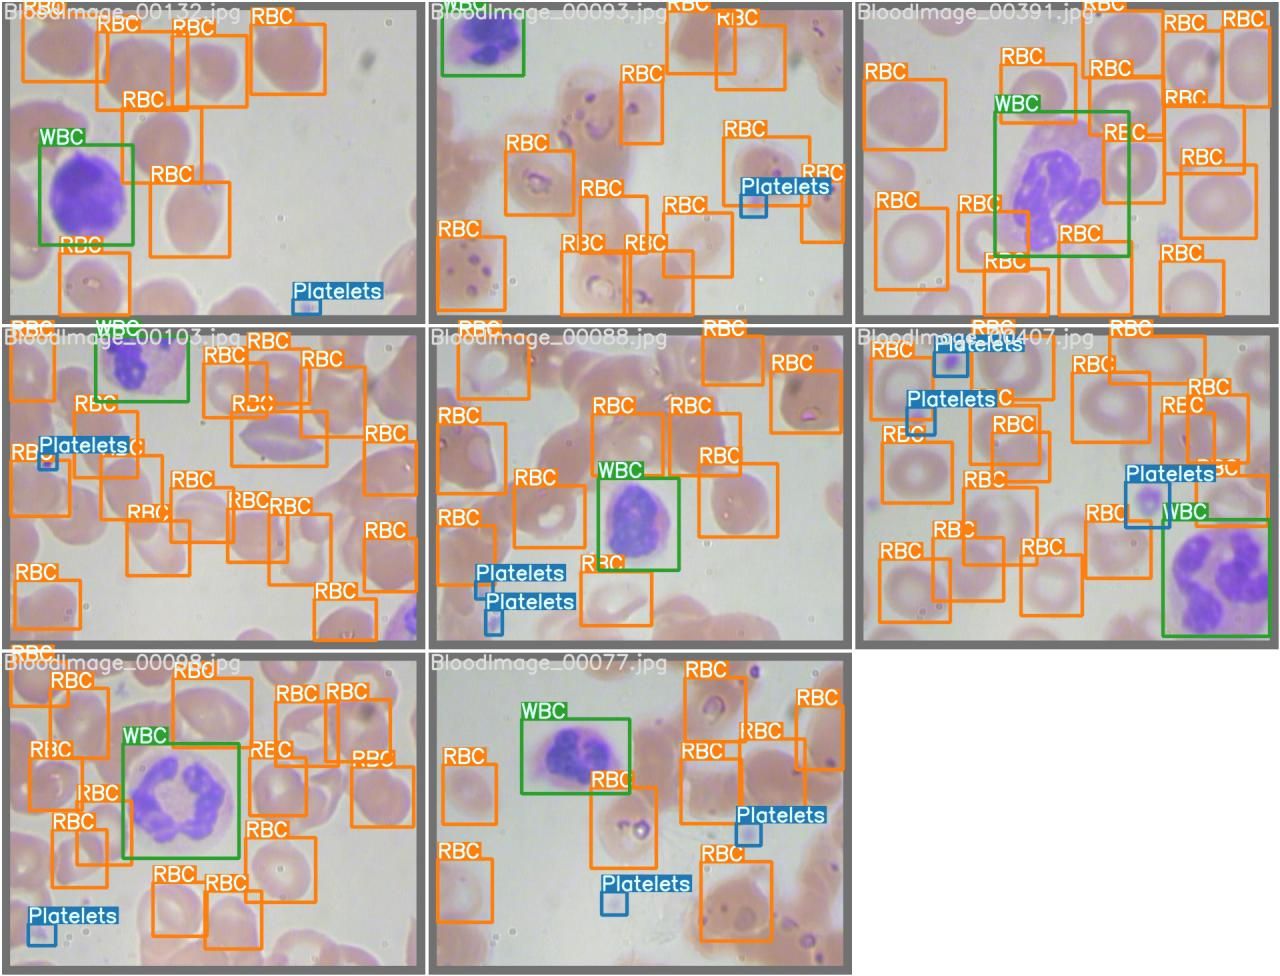

In [37]:
Image(filename='runs/test/exp2/test_batch2_labels.jpg')

#### (2)、Confusion Matrix

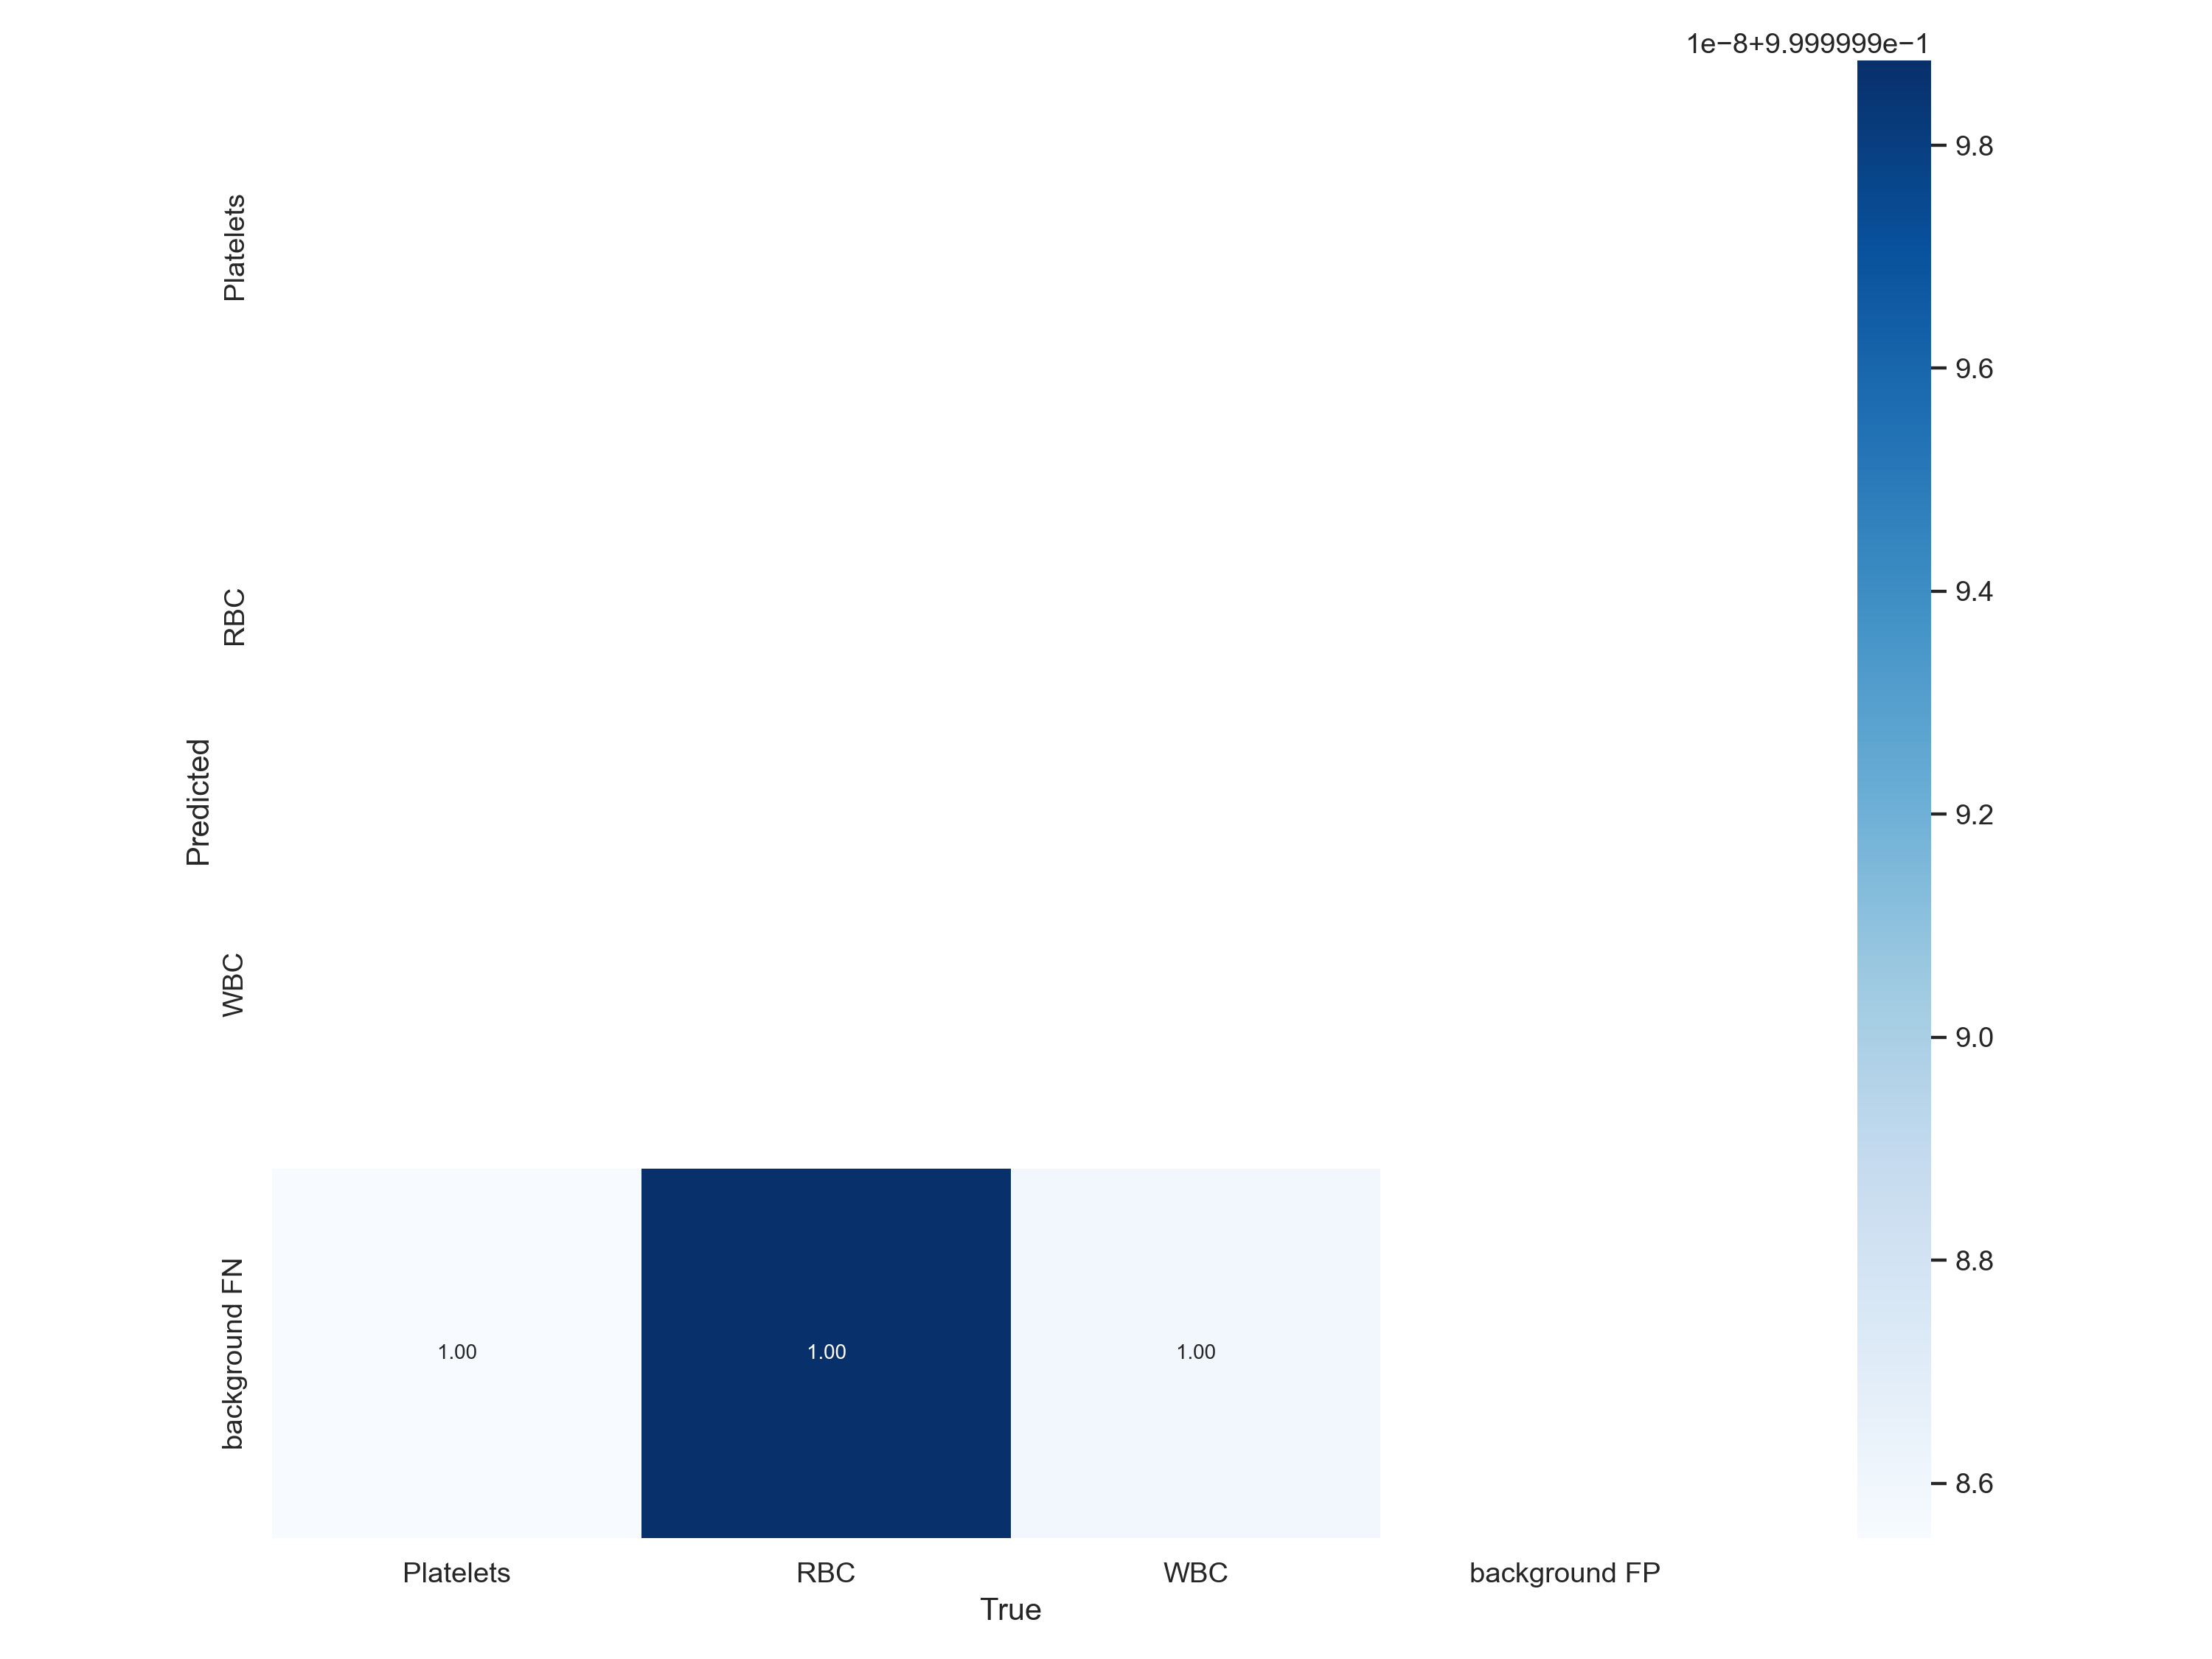

In [38]:
Image(filename='runs/test/exp2/confusion_matrix.png')

#### (3)、PR Curve

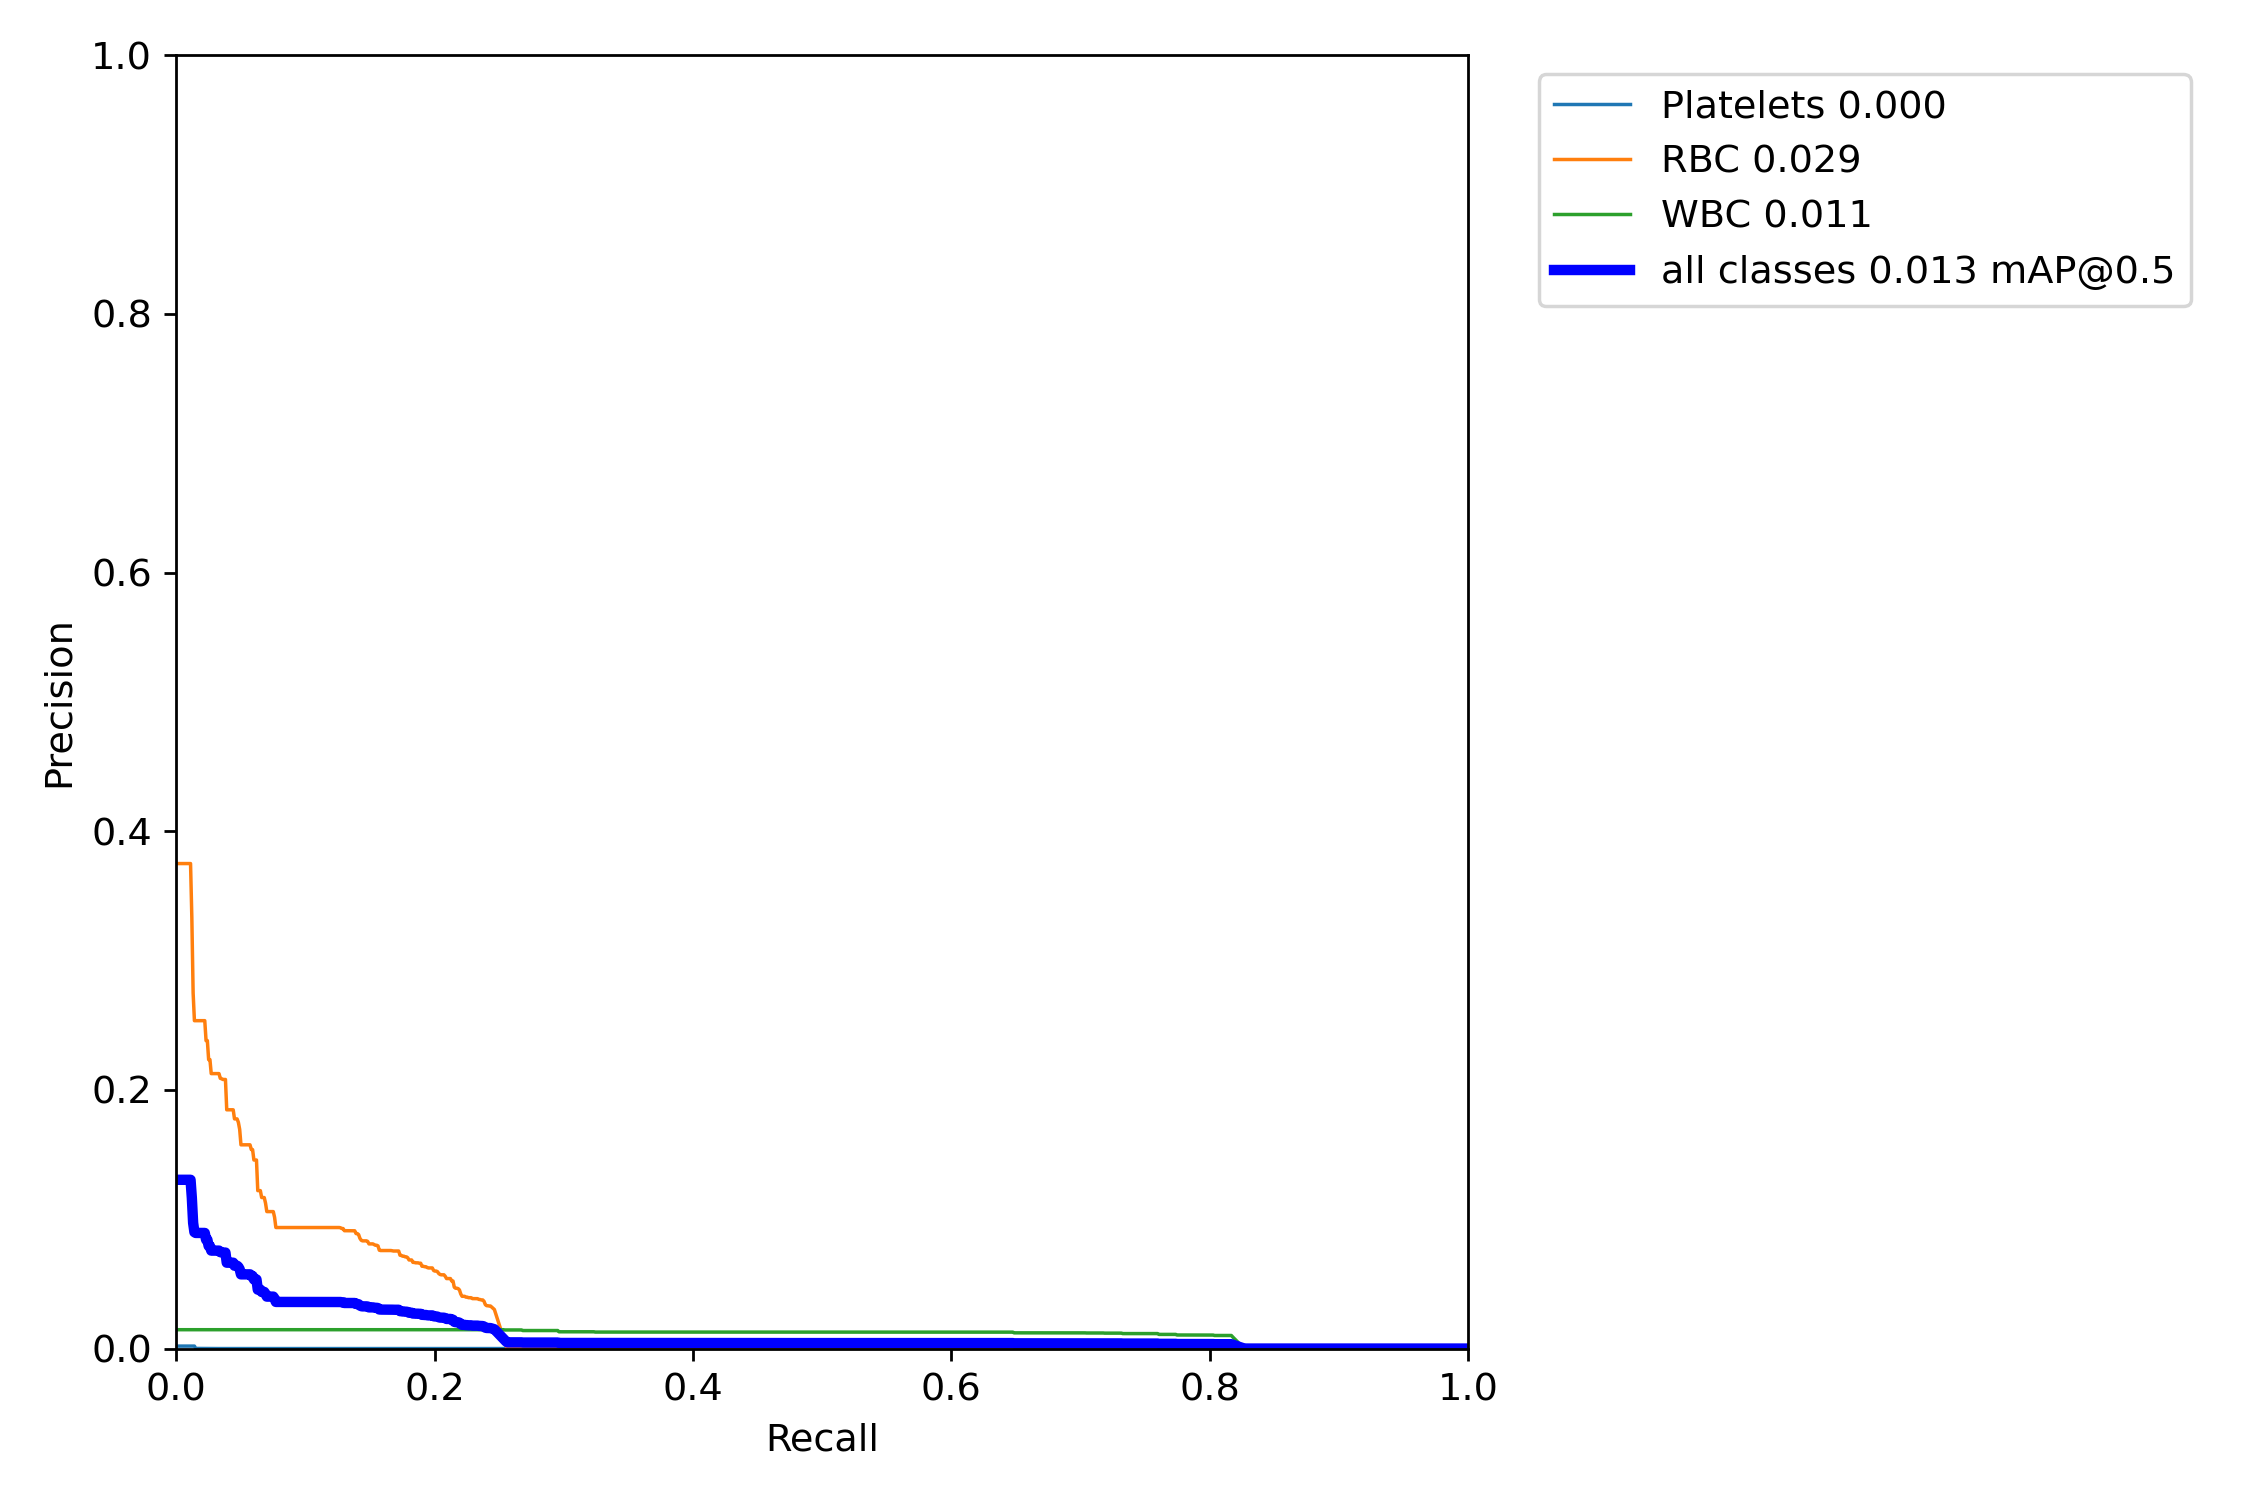

In [39]:
Image(filename='runs/test/exp2/PR_curve.png')